<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/316_conjugate_families.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(sec-distr-coniugate)=
# Distribuzioni coniugate

Obiettivo di questo capitolo è fornire un esempio di derivazione della distribuzione a posteriori scegliendo quale distribuzione a priori una distribuzione coniugata. Esamineremo qui il lo schema beta-binomiale. 

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats
from scipy import integrate
import numpy as np
import pymc as pm
from scipy.stats import beta

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Derivazione della distribuzione a posteriori

Le distribuzioni a priori coniugate sono una categoria speciale di distribuzioni probabilistiche che hanno una proprietà importante: se la distribuzione a priori appartiene a questa categoria, allora la distribuzione a posteriori appartiene anche alla stessa categoria, mantenendo la stessa forma funzionale. Ciò significa che l'aggiornamento delle nostre credenze sul parametro di interesse si riduce semplicemente alla modifica dei parametri della distribuzione a priori. Ad esempio, se utilizziamo una distribuzione a priori Beta e la verosimiglianza è binomiale, allora la distribuzione a posteriori sarà anche una distribuzione Beta.

Anche se le distribuzioni a priori coniugate sono la scelta migliore in termini matematici poiché consentono di calcolare la distribuzione a posteriori in modo analitico senza la necessità di calcoli complessi, le tecniche di inferenza bayesiana moderne consentono di utilizzare qualsiasi distribuzione a priori e non solo quelle coniugate. Tuttavia, le distribuzioni a priori coniugate rimangono uno strumento utile nell'insegnamento dell'inferenza bayesiana. In questo capitolo, esploreremo il modello beta-binomiale, che viene utilizzato per l'inferenza sulla proporzione e che si basa sulla distribuzione a priori Beta e sulla verosimiglianza binomiale.

## Lo schema beta-binomiale 

La distribuzione Beta è una distribuzione di probabilità utilizzata per descrivere la variabilità di una variabile casuale che assume valori nell'intervallo [0,1]. La forma della distribuzione è determinata da due parametri, chiamati $\alpha$ e $\beta$. La distribuzione Beta può essere utilizzata per rappresentare le nostre credenze a priori su una proporzione. Successivamente, quando abbiamo raccolto dei dati e abbiamo un valore osservato per la proporzione, possiamo utilizzare l'aggiornamento bayesiano per trovare la distribuzione a posteriori. Per fare ciò, moltiplichiamo la distribuzione a priori per la verosimiglianza. Questo processo ci permette di aggiornare le nostre credenze in modo formale e rigoroso. Per maggiori dettagli sulla distribuzione Beta si può fare riferimento al capitolo {ref}`cont-rv-distr-notebook`.

Se scegliamo la distribuzione Beta, la distribuzione a priori è

$$
\theta^{\alpha - 1} (1 - \theta)^{\beta - 1}.
$$

Ometto qui il fattore di normalizzazione di cui non ho bisogno perché la normalizzazione verrà eseguita dopo l'aggiornamento bayesiano.

Per una proporzione, la verosimiglianza è data dalla distribuzione Binomiale:

$$
\theta^{y} (1 - \theta)^{n - y}.
$$

Nuovamente, ometto il fattore di normalizzazione.

Per calcolare la distribuzione a posteriori, si moltiplica la funzione nucleo a priori Beta per la funzione nucleo della verosimiglianza Binomiale:

$$
\theta^{\alpha - 1} (1 - \theta)^{\beta - 1} \cdot \theta^{y} (1 - \theta)^{n - y} = \theta^{\alpha - 1 + y} (1 - \theta)^{\beta - 1 + n - y}.
$$

La formula risultante rappresenta la distribuzione Beta non normalizzata con i parametri $\alpha+y$ e $\beta+n-y$. In altre parole, se osserviamo $y$ successi in $n$ prove Bernoulliane e scegliamo una distribuzione a priori Beta con i parametri $\alpha$ e $\beta$, il processo di aggiornamento bayesiano produce una distribuzione a posteriori Beta con i parametri $\alpha+y$ e $\beta+n-y$.

L'esempio appena descritto rappresenta un caso di analisi coniugata. In particolare, la combinazione della funzione di verosimiglianza Binomiale e della distribuzione a priori Beta è nota come il caso coniugato "beta-binomiale", ed è regolato dal seguente teorema.

```{admonition} Teorema
Supponiamo di avere una funzione di verosimiglianza $Bin(n, y \mid \theta)$ e una distribuzione a priori $Beta(\alpha, \beta)$. In questo caso, la distribuzione a posteriori del parametro $\theta$ sarà una distribuzione $Beta(\alpha + y, \beta + n - y)$. 
```

In altre parole, le informazioni a priori rappresentate dalla distribuzione Beta vengono integrate con le informazioni contenute nei dati osservati rappresentati dalla funzione di verosimiglianza Binomiale per produrre una stima più accurata della distribuzione di probabilità a posteriori del parametro $\theta$. Questo risultato è noto come teorema del caso coniugato "beta-binomiale".

### Un esempio concreto

Per fare un esempio concreto, consideriamo i dati di {cite:t}`zetsche_2019future`. In uno studio clinico, 23 partecipanti su 30 hanno riportato aspettative future negative, mentre i restanti 7 hanno riportato aspettative future positive. Indichiamo con $\theta$ la probabilità che un paziente clinico abbia aspettative future negative. Vogliamo stimare la distribuzione a posteriori di $\theta$ avendo osservato 23 "successi" su 30 prove.

In questo caso, i dati osservati ($y = 23$) possono essere considerati come la realizzazione di una sequenza di variabili casuali Bernoulliane, dunque la verosimiglianza è binomiale. Se viene scelta una distribuzione a priori Beta di parametri $\alpha$ e $\beta$, allora la distribuzione a posteriori sarà una Beta di parametri $\alpha + 23$ e $\beta + 30 - 23$.

### La distribuzione a priori

La distribuzione Beta ci permette di esprimere le nostre iniziali credenze su $\theta$, che rappresenta la probabilità di avere un'aspettativa distorta negativamente. Ad esempio, scegliendo una distribuzione a priori $Beta(\alpha = 4, \beta = 4)$ per il parametro $\theta$, esprimiamo la nostra credenza iniziale che vi sia una grande incertezza riguardo all'evento "presenza di un'aspettativa futura distorta negativamente". In particolare, il valore 0.5 è considerato il valore di $\theta$ più plausibile, ma anche gli altri valori del parametro (tranne gli estremi) sono ritenuti piuttosto plausibili. Questa distribuzione a priori esprime la nostra credenza che sia altrettanto probabile avere un'aspettativa futura distorta negativamente o positivamente.

In [3]:
def plot_beta(alpha, beta, mean=False, mode=False):
    theta = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(theta, alpha, beta)
    plt.plot(theta, p_theta_given_y, lw=2, color="k")
    plt.xlabel(r"$\theta$")
    plt.ylabel("$f(\\theta)$")

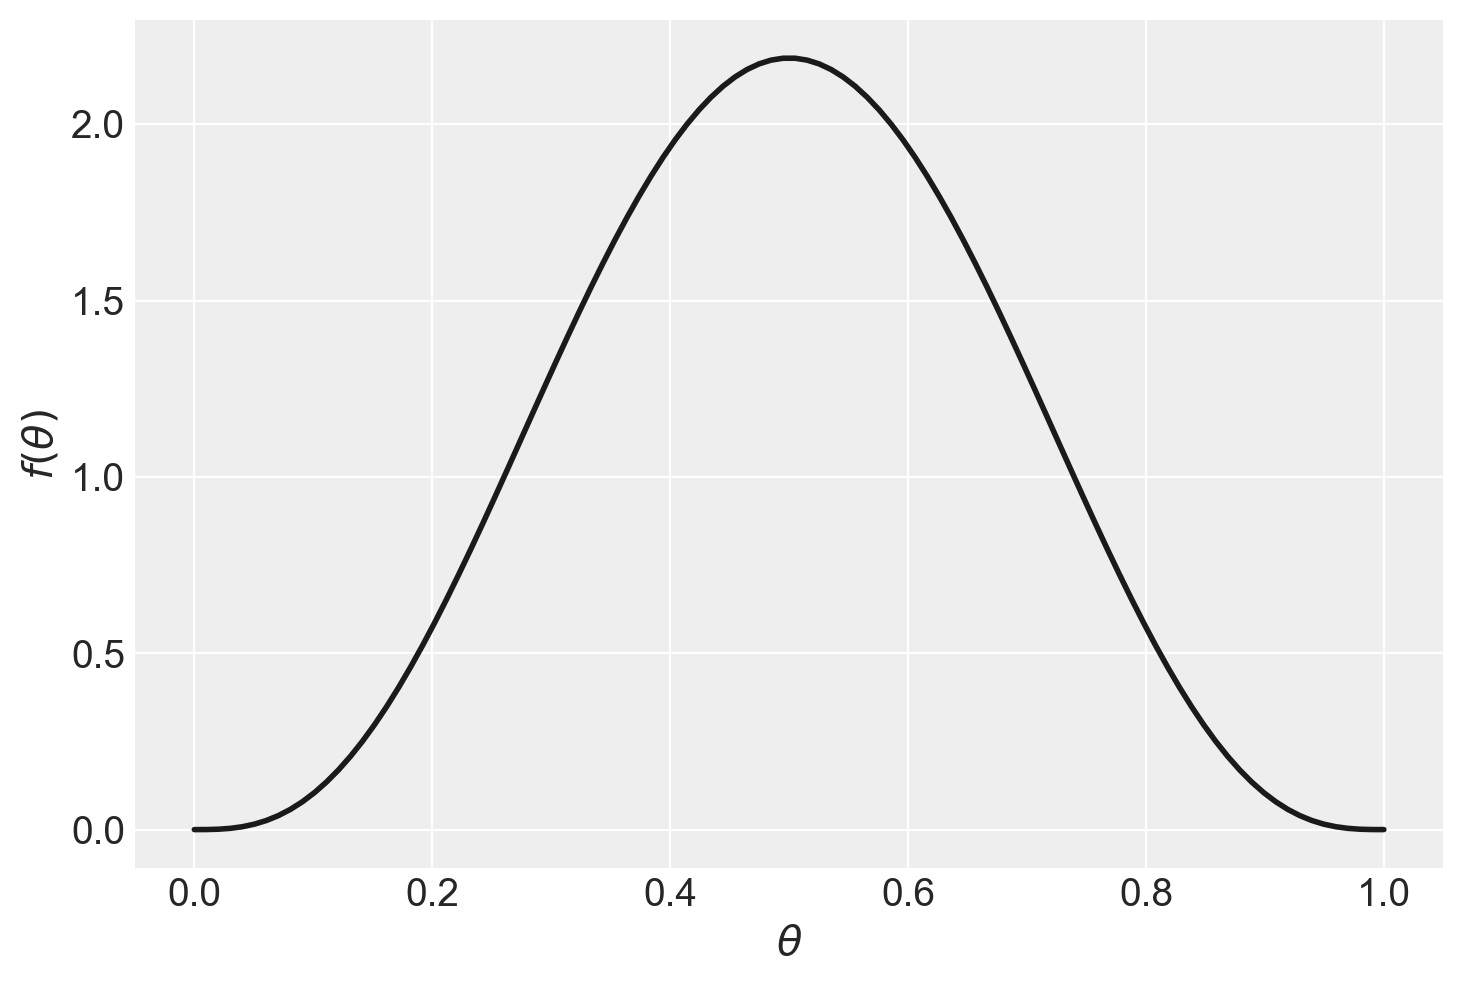

In [4]:
# Plot the Beta(45, 55) prior
plot_beta(4, 4)

Un sommario della distribuzione $Beta(4, 4)$ si ottiene usando la funzione seguente:

In [5]:
def summarize_beta(alpha, beta):
    r"""Summarize a Beta Model for \eqn{\pi}

    @param alpha,beta positive shape parameters of the Beta model

    Return Pandas Series with summary
    """

    mean = alpha / (alpha + beta)
    var = alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))
    sd = np.sqrt(var)

    if alpha < 1 and beta < 1:
        mode = "0 and 1"
    elif alpha <= 1 and beta > 1:
        mode = 0
    elif alpha > 1 and beta < 1:
        mode = 1
    else:
        mode = (alpha - 1) / (alpha + beta - 2)
    return pd.Series({"mean": mean, "mode": mode, "var": var, "sd": sd})

In [6]:
summarize_beta(4, 4)

mean    0.500000
mode    0.500000
var     0.027778
sd      0.166667
dtype: float64

Possiamo quantificare la nostra incertezza calcolando, con un grado di fiducia del 95%, la regione nella quale, in base a tale credenza a priori, si trova il valore del parametro. Per ottenere tale intervallo di credibilità a priori, usiamo la funzione `beta.ppf` di `scipy.stats`. 

In [7]:
li = beta.ppf(0.025, 4, 4)
ls = beta.ppf(0.975, 4, 4)
list([li, ls])

[0.184051567640083, 0.8159484323599169]

Se poniamo $\alpha=10$ e $\beta=10$, anche questa scelta descrive una credenza a priori per la quale è egualmente probabile osservare un'aspettativa futura distorta negativamente o positivamente.

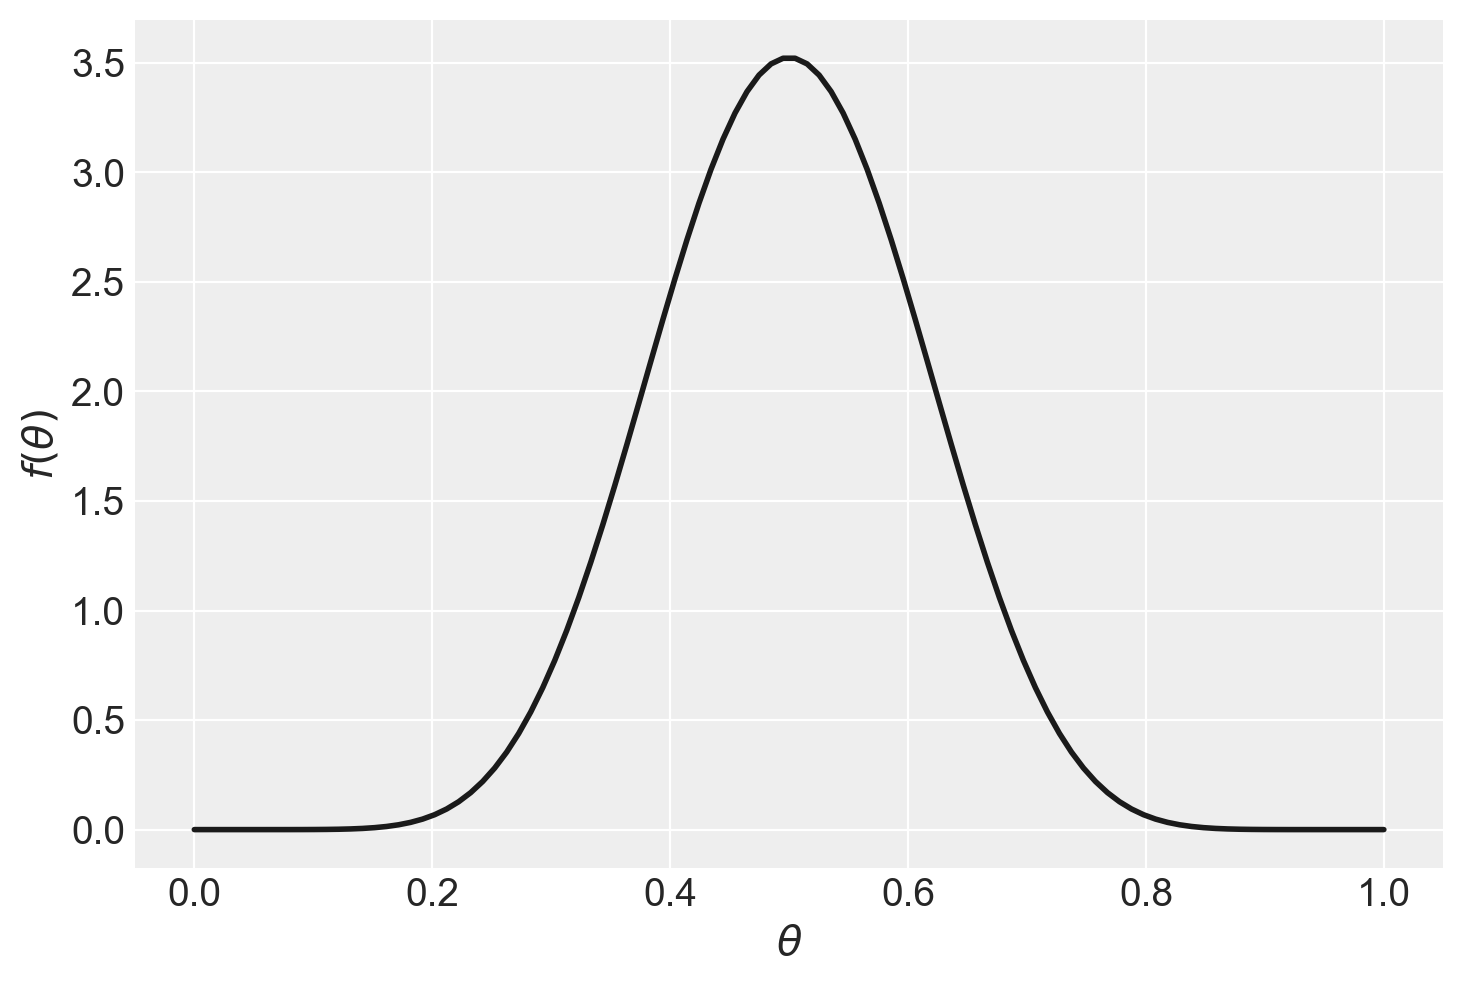

In [8]:
plot_beta(10, 10)

Tuttavia, in questo caso la nostra certezza a priori sul valore del parametro è maggiore, come indicato dall'intervallo di ordine 0.95.

In [9]:
li = beta.ppf(0.025, 10, 10)
ls = beta.ppf(0.975, 10, 10)
list([li, ls])

[0.2886432479169988, 0.7113567520830011]

Quale distribuzione a priori dobbiamo scegliere? In un problema concreto di analisi dei dati, la scelta della distribuzione a priori dipende dalle credenze a priori che vogliamo includere nell'analisi dei dati. Se non abbiamo alcuna informazione a priori, allora è possibile usare $\alpha=1$ e $\beta=1$, che corrisponde ad una distribuzione a priori uniforme. Ma l'uso di distribuzioni a priori uniformi è sconsigliato per vari motivi, inclusa l'instabilità numerica della stima dei parametri. In tali circostanze sarebbe preferibile usare una distribuzione a priori debolmente informativa, come una $Beta(2, 2)$.

Nella discussione presente, quale distribuzione a priori useremo una $Beta(2, 10)$.

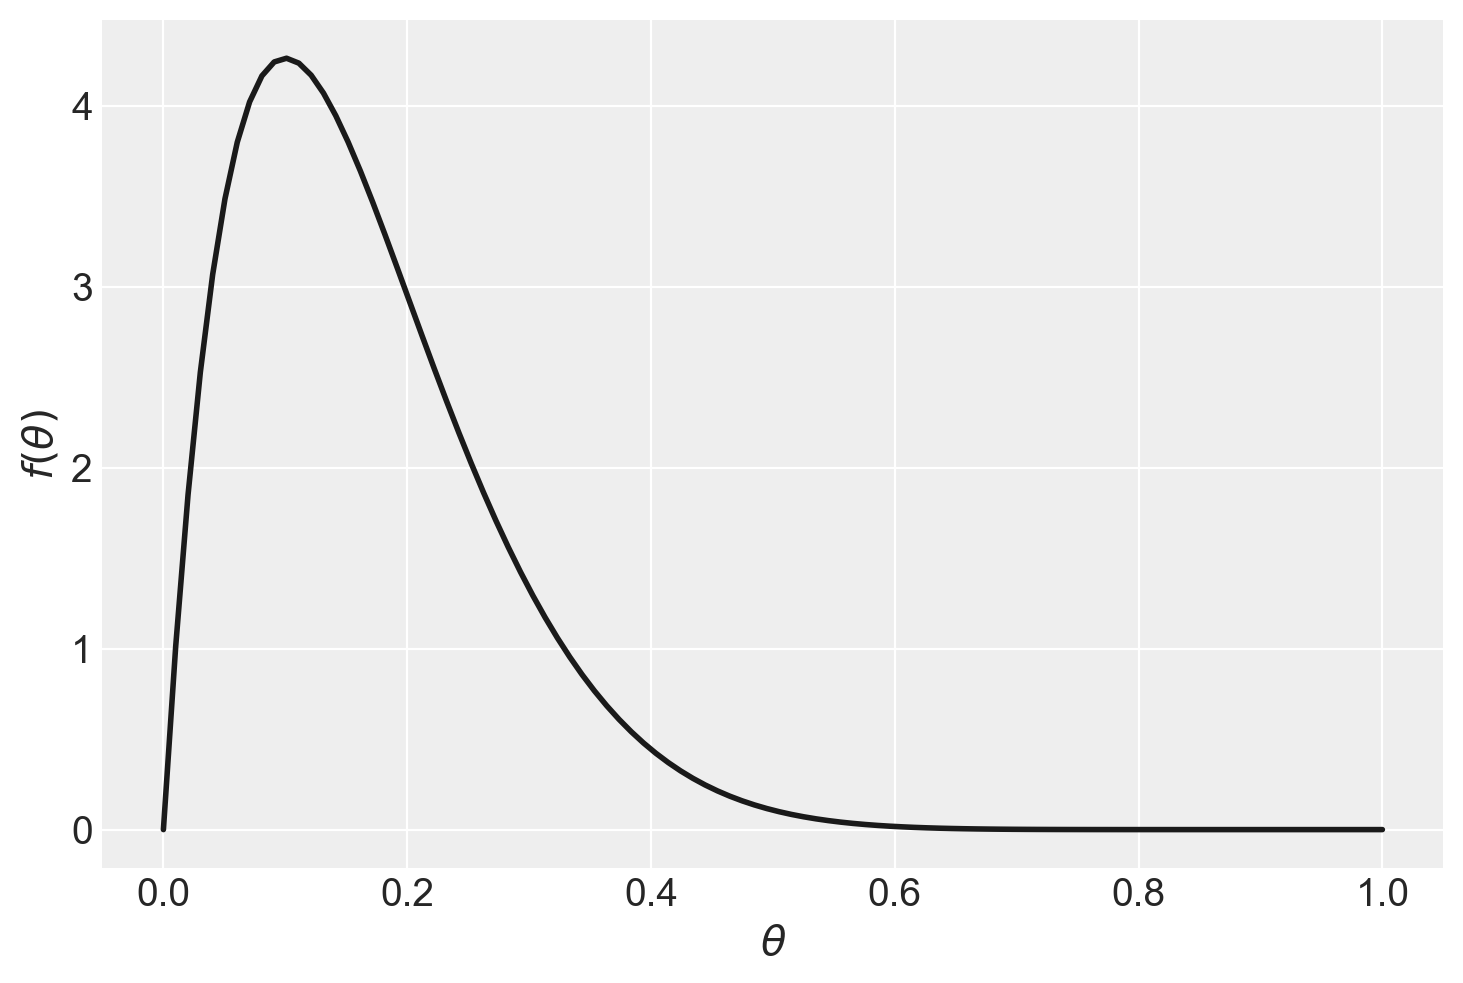

In [10]:
plot_beta(2, 10)

La distribuzione a priori rappresentata dalla $Beta(2,10)$ non è adatta per i dati presentati in {cite:t}`zetsche_2019future`, poiché esprime una credenza iniziale che la probabilità $\theta$ sia inferiore a 0.5, con il valore più probabile intorno al 0.1. Tuttavia, non vi sono motivi per credere che per questa popolazione esista una bassa probabilità di distorsione negativa nelle aspettative future, ma al contrario, è più probabile che ci sia una probabilità relativamente alta di tale distorsione. Quindi, la scelta di una $Beta(2,10)$ viene utilizzata solo per dimostrare l'effetto di tale scelta sulla distribuzione a posteriori, ma non è adeguata per rappresentare le credenze iniziali sulla probabilità di distorsione negativa delle aspettative future nella popolazione in questione.`

### La distribuzione a posteriori

Una volta scelta una distribuzione a priori $Beta(2, 10)$, i cui parametri rispecchiano le nostre credenze iniziali su $\theta$, la distribuzione a posteriori diventa una Beta di parametri $\alpha + y$ e $\beta + n -y$. Per i dati dell'esempio, otteniamo la distribuzione a posteriori $p(\theta \mid n, y) \sim Beta(25, 17)$.

Essendo $\mathbb{E}[Beta(\alpha, \beta)] = \frac{\alpha}{\alpha + \beta}$, il valore atteso a posteriori di $\theta$ può essere calcolato come:

$$
\mathbb{E}_{\text{post}} [\mathrm{Beta}(\alpha + y, \beta + n - y)] = \frac{\alpha + y}{\alpha + \beta +n}.
$$ (eq-ev-post-beta-bin-1)

Rappresentiamo qui sotto graficamente l'aggiornamento bayesiano beta-binomiale per i dati di {cite:t}`zetsche_2019future` nel caso di una distribuzione a priori $Beta(2, 10)$.

In [11]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(
        θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2
    )
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ,
        likelihood / scale_factor,
        lw=4,
        color="b",
        label="likelihood scaled",
        alpha=0.2,
    )
    plt.xlabel(r"$\theta$")
    plt.ylabel("density")
    plt.legend()


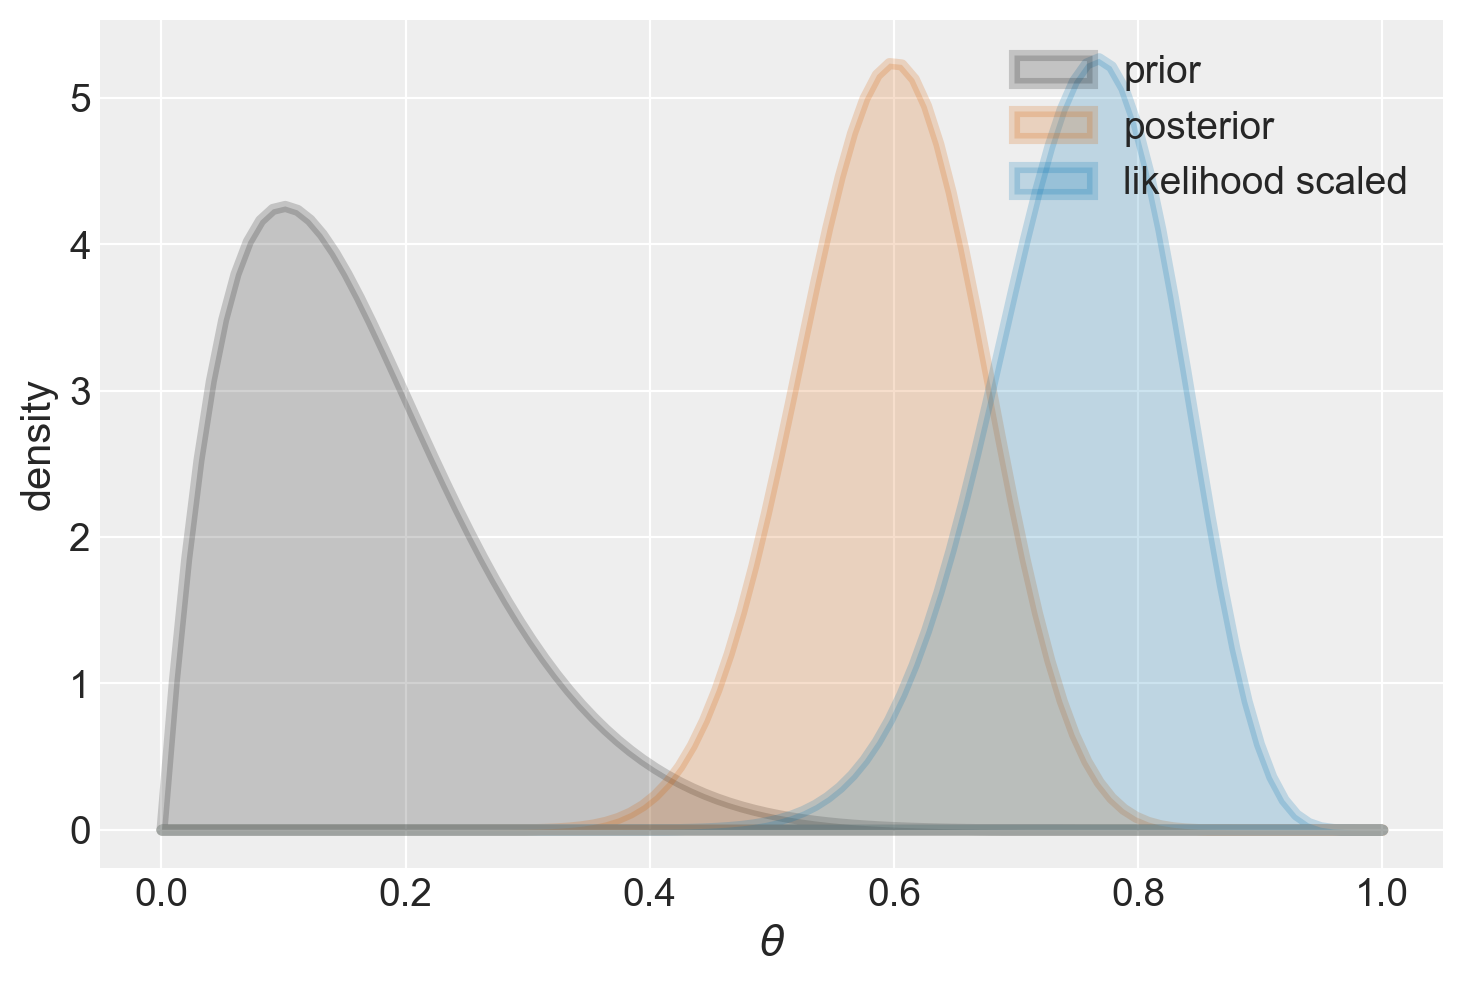

In [12]:
plot_beta_binomial(alpha=2, beta=10, y=23, n=30)

### La ricerca sull'obbedienza di Milgram

Consideriamo un altro esempio relativo alla ricerca di Stanley Milgram discussa da {cite:t}`Johnson2022bayesrules`. Nel 1963, Stanley Milgram presentò una ricerca sulla propensione delle persone a obbedire agli ordini di figure di autorità, anche quando tali ordini possono danneggiare altre persone {cite:t}`milgram1963behavioral`. Nell'articolo, Milgram descrive lo studio come

> consist\[ing\] of ordering a naive subject to administer electric shock to a victim. A simulated shock generator is used, with 30 clearly marked voltage levels that range from IS to 450 volts. The instrument bears verbal designations that range from Slight Shock to Danger: Severe Shock. The responses of the victim, who is a trained confederate of the experimenter, are standardized. The orders to administer shocks are given to the naive subject in the context of a "learning experiment" ostensibly set up to study the effects of punishment on memory. As the experiment proceeds the naive subject is commanded to administer increasingly more intense shocks to the victim, even to the point of reaching the level marked Danger: Severe Shock.

All'insaputa del partecipante, gli shock elettrici erano falsi e l'attore stava solo fingendo di provare il dolore dello shock.

{cite:t}`Johnson2022bayesrules` fanno inferenza sui risultati dello studio di Milgram mediante il modello Beta-Binomiale. Il parametro di interesse è la probabilità $\theta$ che una persona obbedisca all'autorità, anche se ciò comporta il rischio di recare danno ad altri, in questo caso somministrando lo shock più severo. Gli autori ipotizzano che, prima di raccogliere dati, le credenze di Milgram riguardo a $\theta$ possano essere rappresentate mediante una distribuzione Beta con parametri $\alpha=1$ e $\beta=10$.

Sia $y = 26$ il numero di soggetti, su un totale di 40 partecipanti, che hanno accettato di infliggere lo shock più severo. Poiché si assume che ciascun partecipante si comporti in modo indipendente dagli altri, la dipendenza di $y$ da $\theta$ può essere modellata mediante la distribuzione binomiale. Di conseguenza, si giunge al seguente modello bayesiano Beta-Binomiale:

$$
\begin{align}
y \mid \theta & \sim \text{Bin}(n = 40, \theta) \notag\\
\theta & \sim \text{Beta}(1, 10) \; . \notag
\end{align}
$$

Il processo di aggiornamento bayesiano è descritto dalla figura ottenuta con la funzione `plot_beta_binomial()`.

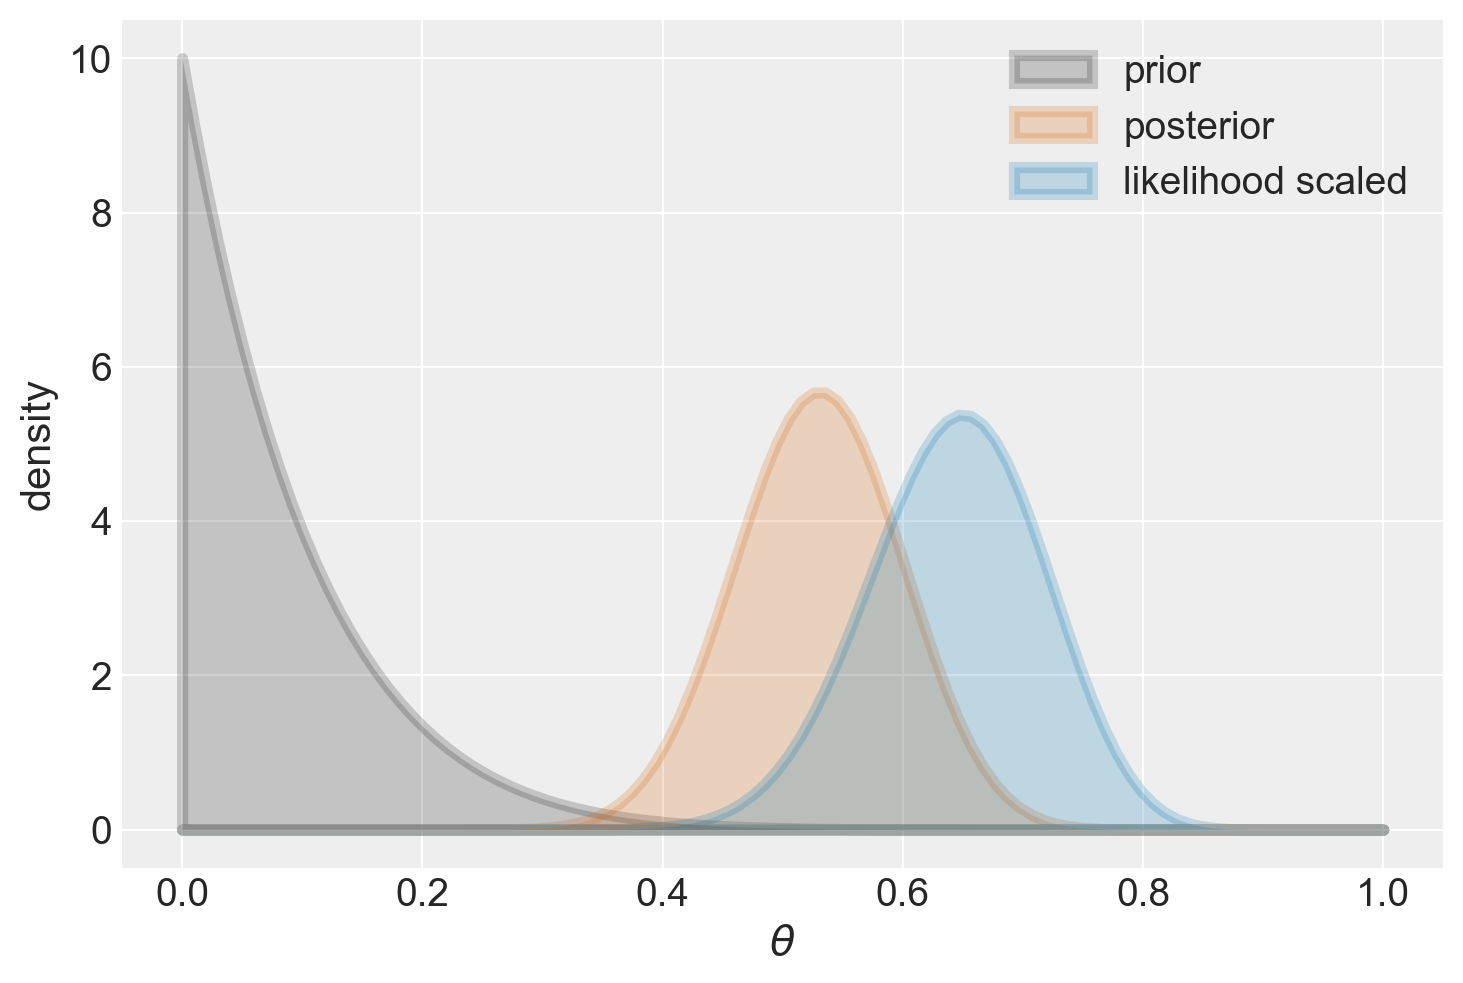

In [13]:
plot_beta_binomial(alpha=1, beta=10, y=26, n=40)

## Inferenza bayesiana con distribuzioni a priori continue

L'inferenza bayesiana sulla proporzione $\theta$ si basa su diversi riepiloghi della distribuzione a posteriori Beta. Il tipo di riepilogo che si calcola dalla distribuzione a posteriori dipende dal tipo di inferenza che si vuole effettuare. In generale, possiamo distinguere due tipi di inferenza.

Il primo tipo (verifica di ipotesi bayesiana) riguarda problemi in cui siamo interessati a valutare la plausibilità che il parametro $\theta$ assuma valori contenuti in un dato intervallo di valori. In questo caso, possiamo calcolare la probabilità a posteriori che $\theta$ cada nell'intervallo di interesse, integrando la distribuzione a posteriori Beta su tale intervallo.

Il secondo tipo di inferenza (intervalli di credibilità) riguarda invece la stima dell'intervallo che contiene il parametro $\theta$ ad un dato livello di probabilità soggettiva. In questo caso, possiamo utilizzare i quantili della distribuzione a posteriori Beta per calcolare l'intervallo di probabilità richiesto. Ad esempio, per stimare l'intervallo che contiene il 95% della massa a posteriori, possiamo calcolare i quantili corrispondenti alla probabilità cumulativa 0.025 e 0.975 della distribuzione a posteriori.

### Verifica di ipotesi bayesiana

Nell'esempio relativo di dati di Milgram, la nostra credenza a posteriori relativa al parametro $\theta$ (ovvero, la probabilità di obbedire all'autorità) è descritta dalla distribuzione Beta(27, 24). Una volta definita la distribuzione a posteriori, possiamo porci ulteriori domande. Ad esempio, potremmo chiederci: qual è la probabilità che il valore di $\theta$ sia maggiore di 0.5?

Per rispondere a questa domanda, possiamo utilizzare la distribuzione a posteriori Beta(27, 24) e calcolare la probabilità che $\theta$ sia maggiore di 0.5 integrando la distribuzione a posteriori da 0.5 a 1. Possiamo esprimere questo calcolo come segue:

$$
P(\theta > 0.5) = 1 - \int_0^{0.5} Beta(\alpha + y, \beta + n - y) d \theta.
$$


In [14]:
1 - stats.beta.cdf(0.5, 27, 24)

0.6640944831173172

### Intervalli di credibilità

Un secondo tipo di inferenza bayesiana è quella che ci porta a costruire gli intervalli di credibilità. Un intervallo di credibilità di ordine $a \in [0, 1]$ è l'intervallo di valori che contiene una proporzione della distribuzione a posteriori pari ad $a$. 

Dato che conosciamo la funzione a posteriori, possiamo semplicemente calcolare i quantili, al livello di probabilità desiderato, per calcolare l'intervallo di credibilità che lascia la stessa probabilità nelle due code.

In [15]:
li = stats.beta.ppf(0.025, 27, 24)
ls = stats.beta.ppf(0.975, 27, 24)
list([li, ls])


[0.3932419761169223, 0.66339490839654]

In alternativa, possiamo calcolare la regione con la più alta densità a posteriori, ovvero la regione (non è necessariamente un intervallo) più corta che contiene la frazione $1 − \alpha$ della densità.

Questo risultato può essere trovato usando la funzione `hdi` del modulo `arviz`. Come input della funzione dobbiamo fornire un campione di valori dalla distribuzione a posteriori.

In [16]:
nsim = 1000000
theta_samples = np.random.beta(27, 24, size=nsim)
az.hdi(theta_samples, hdi_prob=0.95)


array([0.39541187, 0.66562364])

Nel caso presente, l'intervallo di credibilità che lascia la stessa probabilità nelle due code e le regioni HPD sono quasi identici.

## Principali distribuzioni coniugate

Esistono altre combinazioni di verosimiglianza e distribuzione a priori le quali producono una distribuzione a posteriori che ha la stessa densità della distribuzione a priori. Sono elencate qui sotto le più note coniugazioni tra modelli statistici e distribuzioni a priori.

-   Per il modello Normale-Normale $\mathcal{N}(\mu, \sigma^2_0)$, la distribizione iniziale è $\mathcal{N}(\mu_0, \tau^2)$ e la distribuzione finale è $\mathcal{N}\left(\frac{\mu_0\sigma^2 + \bar{y}n\tau^2}{\sigma^2 + n\tau^2}, \frac{\sigma^2\tau^2}{\sigma^2 + n\tau^2} \right)$.
-   Per il modello Poisson-gamma $\text{Po}(\theta)$, la distribizione iniziale è $\Gamma(\lambda, \delta)$ e la distribuzione finale è $\Gamma(\lambda + n \bar{y}, \delta +n)$.
-   Per il modello esponenziale $\text{Exp}(\theta)$, la distribizione iniziale è $\Gamma(\lambda, \delta)$ e la distribuzione finale è $\Gamma(\lambda + n, \delta +n\bar{y})$.
-   Per il modello uniforme-Pareto $\text{U}(0, \theta)$, la distribizione iniziale è $\text{Pa}(\alpha, \varepsilon)$ e la distribuzione finale è $\text{Pa}(\alpha + n, \max(y_{(n)}, \varepsilon))$.

## Commenti e considerazioni finali 

Nel Capitolo è stato spiegato come combinare le conoscenze a priori e le evidenze fornite dai dati per ottenere una stima della distribuzione di probabilità a posteriori del parametro $\theta$, che rappresenta l'incertezza su un evento di interesse. Nel caso in cui $\theta$ rappresenti la probabilità di successo in una sequenza di prove Bernoulliane, è stata utilizzata una distribuzione a priori Beta per esprimere le credenze iniziali su $\theta$. Grazie alla funzione di verosimiglianza binomiale, è stato possibile applicare il teorema di Bayes e determinare la distribuzione a posteriori, anch'essa una distribuzione Beta. Questo metodo di inferenza statistica è noto come schema "beta-binomiale" e consente di calcolare analiticamente i parametri della distribuzione a posteriori utilizzando una distribuzione a priori coniugata. In questo modo, si ottiene una stima più precisa dell'incertezza sul parametro $\theta$ basata sia sulle conoscenze a priori che sui dati osservati.

## Watermark

In [17]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Fri May 05 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.1

numpy     : 1.23.5
pymc      : 5.3.0
seaborn   : 0.12.2
arviz     : 0.15.1
scipy     : 1.10.1
pandas    : 2.0.1
matplotlib: 3.7.1

